In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def load_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [3]:
def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame, minimum_contribution = 100) -> pd.DataFrame:
    developers = df["assignees"].value_counts()
    filtered_developers = developers.index[developers >= minimum_contribution]
    df = df[df["assignees"].isin(filtered_developers)]

    df["text"] = df.apply(lambda x: str(x["issue_title"]) + "\n" + str(x["issue_body"]), axis=1)
    df["owner_id"] = pd.factorize(df["assignees"])[0]

    min_length = 15
    max_length = 1023
    df = df[df["text"].str.len().gt(min_length) & df["text"].str.len().lt(max_length)]

    return df

/tmp/ipykernel_4101018/664243860.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df.apply(lambda x: str(x["issue_title"]) + "\n" + str(x["issue_body"]), axis=1)
/tmp/ipykernel_4101018/664243860.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["owner_id"] = pd.factorize(df["assignees"])[0]


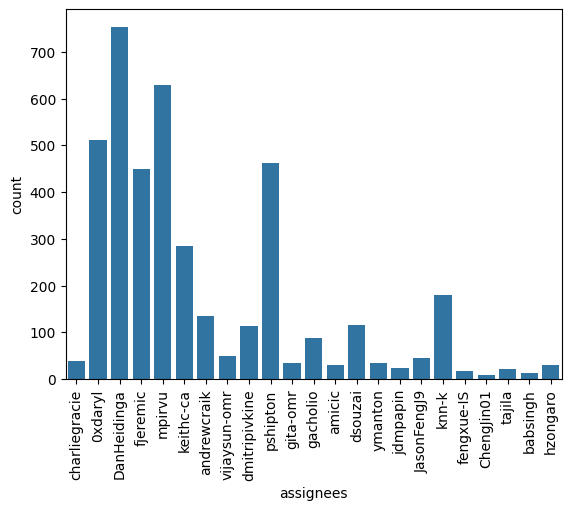

In [4]:
data_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9_issues_cleaned.csv"

df = load_dataframe(data_path)
df = prepare_dataframe(df, 40)
df = clean_data(df)

fig = sns.countplot(x = "assignees", data=df)
for item in fig.get_xticklabels():
    item.set_rotation(90)

In [5]:

text_lengths = df['text'].apply(len)

<Axes: xlabel='text', ylabel='Count'>

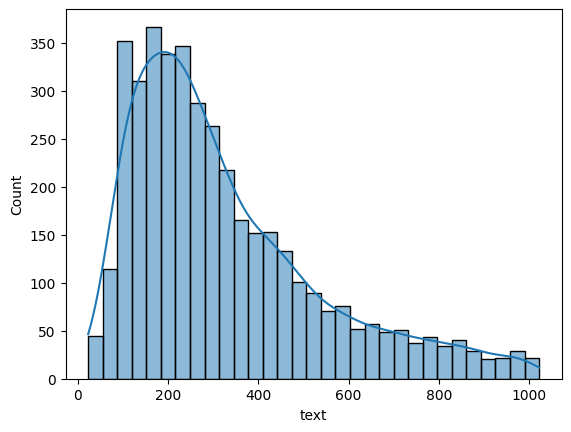

In [6]:
sns.histplot(text_lengths, kde=True)

In [7]:
num_classes = len(df["assignees"].unique())
num_classes

23

In [8]:
import torch.nn as nn
from transformers import RobertaModel, RobertaTokenizer
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, model_name: str, output_size, embed_size=1024, dropout = 0.1) -> None:
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(model_name, output_hidden_states=True)
        filter_sizes = [3, 4, 5, 6]
        num_filters = 256
        self._tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.convs1 = nn.ModuleList([nn.Conv2d(4, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, output_size)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids, attention_mask = attention_mask)[2][-4:]
        x = torch.stack(x, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)  

        return self.relu(logit)
    
    def tokenizer(self) -> RobertaTokenizer:
        return self._tokenizer

In [9]:
labels_dict = {
    assignee: idx for idx, assignee in enumerate(df["assignees"].unique()) 
}

labels_dict

{'charliegracie': 0,
 '0xdaryl': 1,
 'DanHeidinga': 2,
 'fjeremic': 3,
 'mpirvu': 4,
 'keithc-ca': 5,
 'andrewcraik': 6,
 'vijaysun-omr': 7,
 'dmitripivkine': 8,
 'pshipton': 9,
 'gita-omr': 10,
 'gacholio': 11,
 'amicic': 12,
 'dsouzai': 13,
 'ymanton': 14,
 'jdmpapin': 15,
 'JasonFengJ9': 16,
 'knn-k': 17,
 'fengxue-IS': 18,
 'ChengJin01': 19,
 'tajila': 20,
 'babsingh': 21,
 'hzongaro': 22}

In [10]:
import torch
import numpy as np


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_seq_length: int = 514):
        self.tokenizer = tokenizer
        self.labels = [labels_dict[label] for label in df["assignees"]]
        self.texts = [
            self.tokenizer(
                text,
                padding="max_length",
                max_length=max_seq_length,
                truncation=True,
                return_tensors="pt",
            )
            for text in df["text"]
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [11]:
import time
import torch
import torch.nn as nn
from torch.optim import Adam
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import logging


logger = logging.getLogger()
logging.basicConfig(
    format="%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S",
    level=logging.DEBUG,
    handlers=[
        logging.FileHandler(f"../logs/lbt_p_{time.time()}.log"),
        logging.StreamHandler(),
    ],
)


def train(model, tokenizer, train_data, val_data, learning_rate, epochs, out_file):
    train, val = Dataset(train_data, tokenizer), Dataset(val_data, tokenizer)
    batch_size = 20

    train_dataloader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=True
    )
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    best_loss = float("inf")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        logger.info("Using CUDA...")
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        logger.info(f"Epoch: {epoch_num}")
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_id = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        val_loss = total_loss_val / len(val_data)

        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}"
        logger.info(log)

        if val_loss < best_loss:
            logger.info("Found new best model. Saving weights...")
            torch.save(model.state_dict(), out_file)
            best_loss = val_loss


EPOCHS = 20
base_model = "roberta-large"
model = Classifier(base_model, num_classes)
tokenizer = model.tokenizer()
LR = 1e-6

df_train, df_val, df_test = np.split(
    df.sample(frac=1, random_state=42), [int(0.8 * len(df)), int(0.9 * len(df))]
)

print(len(df_train))

train(model, tokenizer, df_train, df_val, LR, EPOCHS, "teacher.pt")


12:46:40,592 urllib3.connectionpool DEBUG Starting new HTTPS connection (1): huggingface.co:443


12:46:40,768 urllib3.connectionpool DEBUG https://huggingface.co:443 "HEAD /roberta-large/resolve/main/config.json HTTP/1.1" 200 0
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
12:46:43,451 urllib3.connectionpool DEBUG https://huggingface.co:443 "HEAD /roberta-large/resolve/main/vocab.json HTTP/1.1" 200 0
/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


3255


12:46:46,617 root INFO Using CUDA...
12:46:47,406 root INFO Epoch: 0
100%|██████████| 163/163 [03:51<00:00,  1.42s/it]
12:50:48,893 root INFO Epochs: 1 | Train Loss:  0.137                 | Train Accuracy:  0.247                 | Val Loss:  0.130                 | Val Accuracy:  0.324
12:50:48,895 root INFO Found new best model. Saving weights...
12:50:52,753 root INFO Epoch: 1
 39%|███▊      | 63/163 [01:29<02:22,  1.43s/it]

In [ ]:
from transformers import RobertaConfig

In [ ]:
RobertaConfig.from_pretrained("roberta-large")

12:31:41,149 urllib3.connectionpool DEBUG https://huggingface.co:443 "HEAD /roberta-large/resolve/main/config.json HTTP/1.1" 200 0


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}